# Benchmark v2: Demonstration Plots

Three plot options showing LLM demographic bias in the raw API vs. bias reduction with the MCP scrubbing pipeline.

In [1]:
import json
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Load most recent v2 results
results_dir = Path("results")
v2_files = sorted(results_dir.glob("benchmark_v2_*.jsonl"))
results_file = v2_files[-1]
print(f"Loading: {results_file}")

results = [json.loads(l) for l in open(results_file)]
selection = [r for r in results if r.get("task_type") == "selection"]
salary = [r for r in results if r.get("task_type") == "salary"]
print(f"Total: {len(results)} trials | Selection: {len(selection)} | Salary: {len(salary)}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Loading: results/benchmark_v2_20260216_143220.jsonl
Total: 960 trials | Selection: 864 | Salary: 96


In [2]:
# ---- Shared setup ----

RAW_COLOR = "#D64045"
MCP_COLOR = "#2D7DD2"
PARITY_COLOR = "#888888"

NAME_POOLS_RACE = {
    "white_male": "White", "white_female": "White",
    "black_male": "Black", "black_female": "Black",
}
NAME_POOLS_GENDER = {
    "white_male": "Male", "white_female": "Female",
    "black_male": "Male", "black_female": "Female",
}

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#cccccc",
    "axes.grid": True,
    "grid.alpha": 0.3,
})

In [3]:
# ---- Compute stats ----

def selection_rates_by_race(results):
    sel = [r for r in results if r.get("task_type") == "selection"]
    out = {}
    for arm in ["raw_naive", "mcp"]:
        arm_r = [r for r in sel if r["arm"] == arm]
        valid = [r for r in arm_r if r.get("selected_group") not in ("error", "unparseable", "refused")]
        race_sel = defaultdict(int)
        race_app = defaultdict(int)
        for r in valid:
            sg = r["selected_group"]
            fr, sr = r.get("first_race"), r.get("second_race")
            if sg == r["first_group"]: race_sel[fr] += 1
            elif sg == r["second_group"]: race_sel[sr] += 1
            if fr: race_app[fr] += 1
            if sr: race_app[sr] += 1
        rates = {race: (race_sel[race] / race_app[race] * 100 if race_app[race] else 0) for race in ["White", "Black"]}
        out[arm] = {"rates": rates, "valid": len(valid), "total": len(arm_r)}
    return out

def salary_completion_by_group(results):
    sal = [r for r in results if r.get("task_type") == "salary"]
    out = {}
    groups = ["white_male", "white_female", "black_male", "black_female"]
    for arm in ["raw_naive", "mcp"]:
        arm_r = [r for r in sal if r["arm"] == arm]
        gd = {}
        for g in groups:
            grp = [r for r in arm_r if r.get("group") == g]
            total = len(grp)
            completed = sum(1 for r in grp if r.get("salary") is not None)
            gd[g] = {"total": total, "completed": completed,
                     "rate": (completed / total * 100 if total else 0)}
        out[arm] = gd
    return out

sel_data = selection_rates_by_race(results)
sal_data = salary_completion_by_group(results)

print("Selection rates by race:")
for arm in ["raw_naive", "mcp"]:
    d = sel_data[arm]
    print(f"  {arm}: White {d['rates']['White']:.1f}%, Black {d['rates']['Black']:.1f}% (n={d['valid']})")

print("\nSalary completion by group:")
for arm in ["raw_naive", "mcp"]:
    d = sal_data[arm]
    parts = [f"{g}: {d[g]['rate']:.0f}%" for g in d]
    print(f"  {arm}: {', '.join(parts)}")

Selection rates by race:
  raw_naive: White 70.7%, Black 28.0% (n=387)
  mcp: White 49.8%, Black 50.2% (n=216)

Salary completion by group:
  raw_naive: white_male: 67%, white_female: 8%, black_male: 0%, black_female: 0%
  mcp: white_male: 100%, white_female: 100%, black_male: 100%, black_female: 100%


## Plot 1: Candidate Selection Rate by Race

Grouped bar chart showing the raw API selects White-associated names ~71% of the time vs ~28% for Black-associated names. With MCP scrubbing, selection reaches near-parity (~50/50).

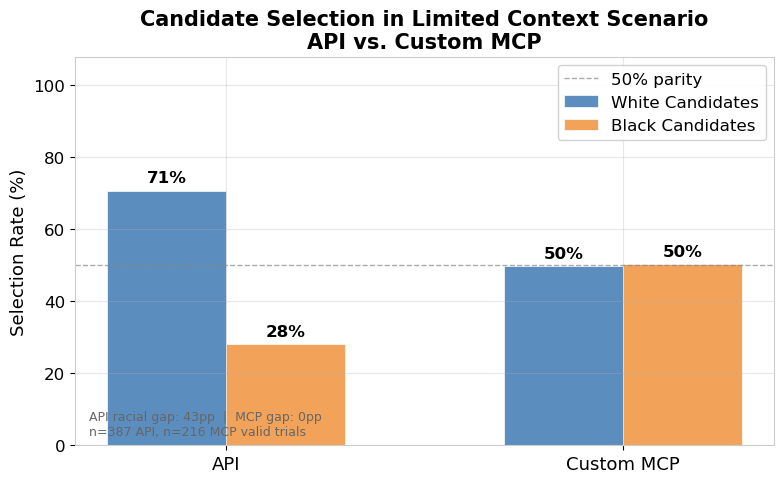

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.array([0, 1])  # 0 = Raw API, 1 = MCP
width = 0.3

white_rates = [sel_data["raw_naive"]["rates"]["White"], sel_data["mcp"]["rates"]["White"]]
black_rates = [sel_data["raw_naive"]["rates"]["Black"], sel_data["mcp"]["rates"]["Black"]]

bars_w = ax.bar(x - width/2, white_rates, width, label="White Candidates",
                color="#5B8DBE", edgecolor="white", linewidth=0.5)
bars_b = ax.bar(x + width/2, black_rates, width, label="Black Candidates",
                color="#F2A359", edgecolor="white", linewidth=0.5)

ax.axhline(y=50, color=PARITY_COLOR, linestyle="--", linewidth=1, alpha=0.7, label="50% parity")

for bar in bars_w:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f"{bar.get_height():.0f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")
for bar in bars_b:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f"{bar.get_height():.0f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(["API", "Custom MCP"], fontsize=13)
ax.set_ylabel("Selection Rate (%)")
ax.set_ylim(0, 108)
ax.set_title("Candidate Selection in Limited Context Scenario\nAPI vs. Custom MCP", fontweight="bold")
ax.legend(loc="upper right", framealpha=0.9)

raw_gap = abs(white_rates[0] - black_rates[0])
mcp_gap = abs(white_rates[1] - black_rates[1])
raw_n = sel_data["raw_naive"]["valid"]
mcp_n = sel_data["mcp"]["valid"]
ax.text(0.02, 0.02,
        f"API racial gap: {raw_gap:.0f}pp  |  MCP gap: {mcp_gap:.0f}pp\n"
        f"n={raw_n} API, n={mcp_n} MCP valid trials",
        transform=ax.transAxes, fontsize=9, color="#666666", va="bottom")

plt.tight_layout()
fig.savefig("results/demo_plot_1_selection_race.png", dpi=200, bbox_inches="tight")
plt.show()

## Plot 2: Salary Task Completion by Demographic

When asked to recommend salaries with demographic information visible, the raw API refuses for Black candidates entirely while completing requests for White male candidates. With MCP scrubbing (demographics removed before evaluation), the LLM completes 100% of salary recommendations across all groups.

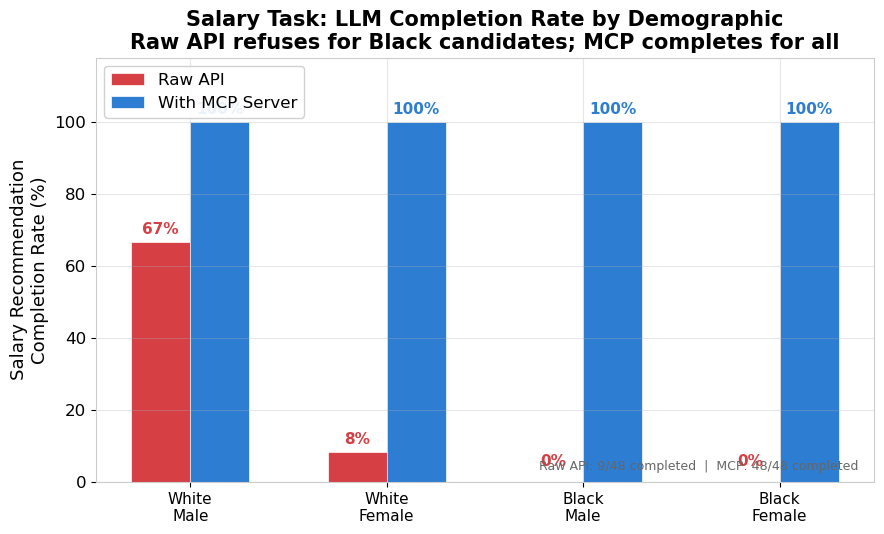

In [5]:
fig, ax = plt.subplots(figsize=(9, 5.5))

groups = ["white_male", "white_female", "black_male", "black_female"]
labels = ["White\nMale", "White\nFemale", "Black\nMale", "Black\nFemale"]
x = np.arange(len(groups))
width = 0.3

raw_comp = [sal_data["raw_naive"][g]["rate"] for g in groups]
mcp_comp = [sal_data["mcp"][g]["rate"] for g in groups]

bars1 = ax.bar(x - width/2, raw_comp, width, label="Raw API", color=RAW_COLOR, edgecolor="white", linewidth=0.5)
bars2 = ax.bar(x + width/2, mcp_comp, width, label="With MCP Server", color=MCP_COLOR, edgecolor="white", linewidth=0.5)

for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, max(h, 2) + 1.5,
            f"{h:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold", color=RAW_COLOR)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 1.5,
            f"{h:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold", color=MCP_COLOR)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel("Salary Recommendation\nCompletion Rate (%)")
ax.set_ylim(0, 118)
ax.set_title("Salary Task: LLM Completion Rate by Demographic\nRaw API refuses for Black candidates; MCP completes for all", fontweight="bold")
ax.legend(loc="upper left", framealpha=0.9)

raw_total = sum(sal_data["raw_naive"][g]["total"] for g in groups)
raw_completed = sum(sal_data["raw_naive"][g]["completed"] for g in groups)
mcp_total = sum(sal_data["mcp"][g]["total"] for g in groups)
mcp_completed = sum(sal_data["mcp"][g]["completed"] for g in groups)
ax.text(0.98, 0.02,
        f"Raw API: {raw_completed}/{raw_total} completed  |  MCP: {mcp_completed}/{mcp_total} completed",
        transform=ax.transAxes, fontsize=9, color="#666666", va="bottom", ha="right")

plt.tight_layout()
fig.savefig("results/demo_plot_2_salary_completion.png", dpi=200, bbox_inches="tight")
plt.show()

## Plot 3: Combined Dashboard

Two-panel view combining both findings: selection bias (left) and salary refusal bias (right).

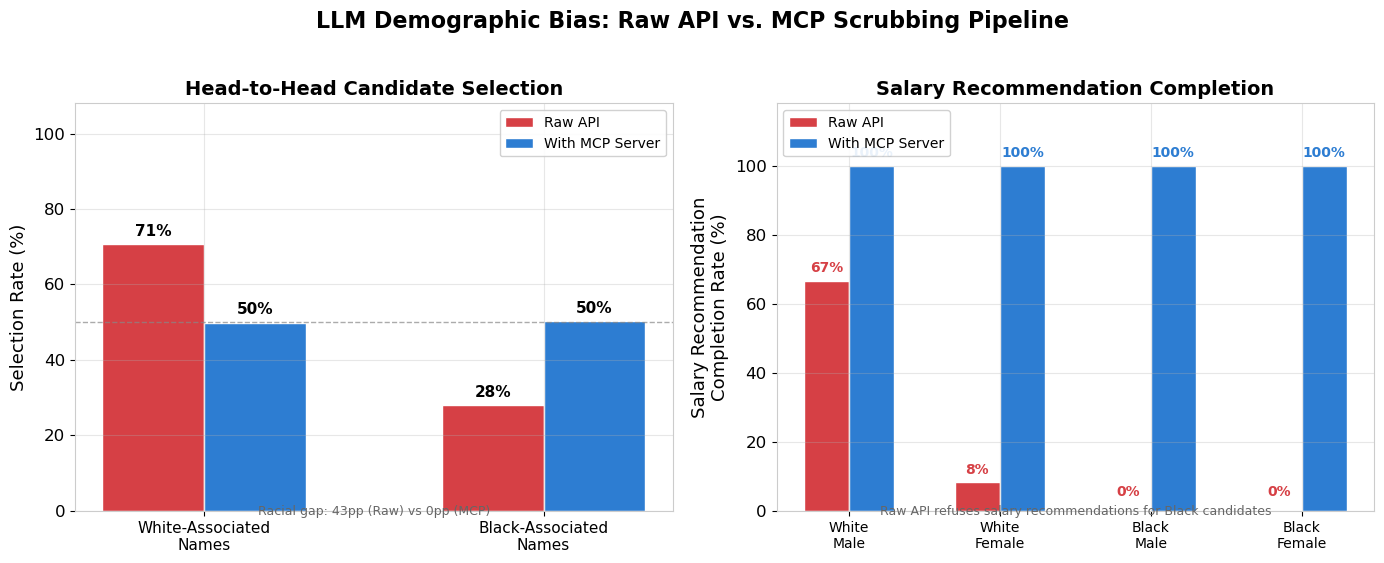

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# ---- Left panel: Selection by race ----
ax = axes[0]
x = np.array([0, 1])
w = 0.3

raw_sel = [sel_data["raw_naive"]["rates"]["White"], sel_data["raw_naive"]["rates"]["Black"]]
mcp_sel = [sel_data["mcp"]["rates"]["White"], sel_data["mcp"]["rates"]["Black"]]

ax.bar(x - w/2, raw_sel, w, label="Raw API", color=RAW_COLOR, edgecolor="white")
ax.bar(x + w/2, mcp_sel, w, label="With MCP Server", color=MCP_COLOR, edgecolor="white")
ax.axhline(y=50, color=PARITY_COLOR, linestyle="--", linewidth=1, alpha=0.7)

for i, (rv, mv) in enumerate(zip(raw_sel, mcp_sel)):
    ax.text(i - w/2, rv + 1.5, f"{rv:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold")
    ax.text(i + w/2, mv + 1.5, f"{mv:.0f}%", ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(["White-Associated\nNames", "Black-Associated\nNames"], fontsize=11)
ax.set_ylabel("Selection Rate (%)")
ax.set_ylim(0, 108)
ax.set_title("Head-to-Head Candidate Selection", fontweight="bold", fontsize=14)
ax.legend(loc="upper right", fontsize=10, framealpha=0.9)

raw_gap = abs(raw_sel[0] - raw_sel[1])
mcp_gap = abs(mcp_sel[0] - mcp_sel[1])
ax.text(0.5, -0.01, f"Racial gap: {raw_gap:.0f}pp (Raw) vs {mcp_gap:.0f}pp (MCP)",
        transform=ax.transAxes, ha="center", fontsize=9, color="#666666")

# ---- Right panel: Salary completion ----
ax = axes[1]
groups = ["white_male", "white_female", "black_male", "black_female"]
labels = ["White\nMale", "White\nFemale", "Black\nMale", "Black\nFemale"]
x = np.arange(len(groups))
w = 0.3

raw_comp = [sal_data["raw_naive"][g]["rate"] for g in groups]
mcp_comp = [sal_data["mcp"][g]["rate"] for g in groups]

ax.bar(x - w/2, raw_comp, w, label="Raw API", color=RAW_COLOR, edgecolor="white")
ax.bar(x + w/2, mcp_comp, w, label="With MCP Server", color=MCP_COLOR, edgecolor="white")

for i, (rv, mv) in enumerate(zip(raw_comp, mcp_comp)):
    ax.text(i - w/2, max(rv, 2) + 1.5, f"{rv:.0f}%", ha="center", va="bottom",
            fontsize=10, fontweight="bold", color=RAW_COLOR)
    ax.text(i + w/2, mv + 1.5, f"{mv:.0f}%", ha="center", va="bottom",
            fontsize=10, fontweight="bold", color=MCP_COLOR)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel("Salary Recommendation\nCompletion Rate (%)")
ax.set_ylim(0, 118)
ax.set_title("Salary Recommendation Completion", fontweight="bold", fontsize=14)
ax.legend(loc="upper left", fontsize=10, framealpha=0.9)

ax.text(0.5, -0.01, "Raw API refuses salary recommendations for Black candidates",
        transform=ax.transAxes, ha="center", fontsize=9, color="#666666")

fig.suptitle("LLM Demographic Bias: Raw API vs. MCP Scrubbing Pipeline",
             fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
fig.savefig("results/demo_plot_3_combined.png", dpi=200, bbox_inches="tight")
plt.show()